# Synthetic Data Generation

We will use a pre-tuned model to produce data. The model output should be a 3D array with condition, signaling node and time point for dimensions. The model output will be sub-sampled to produce the synthetic dataset.

In [1]:
import torch
import numpy
import bionetwork
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

## Run the pre-trained model

Run pre-trained model to produce synthetic data that are going to be used to evaluate the toy model. We will store both `fullYfull` which is the Y for all model states as well as the `X` that we used.

Prepare `X` and `fullYFull` for sub-sampling. `X` should be a matrix with Drug and Cell line as indexes and Targeted genes as columns. `fullYFull` should be matrix with Drug, Cell line, and Gene as indexes and Time points as columns.

The Cell line is also simulated by randomizing the bias randomly for each cell line and then run the model.

In [5]:
# Setup Parameters
N = 200
inputAmplitude = 3
projectionAmplitude = 1.2
seed = 123
torch.manual_seed(seed)
numpy.random.seed(seed)

# Load network
networkList, nodeNames, modeOfAction = bionetwork.loadNetwork('data/KEGGnet-Model.tsv')
annotation = pandas.read_csv('data/KEGGnet-Annotation.tsv', sep='\t')
bionetParams = bionetwork.trainingParameters(iterations = 150, clipping=1, leak=0.01)

inName = annotation.loc[annotation['ligand'],'code'].values
outName = annotation.loc[annotation['TF'],'code'].values
inName = numpy.intersect1d(nodeNames, inName)
outName = numpy.intersect1d(nodeNames, outName)

synthetic_data_combined = []
X_combined = []

# Generate data for 7 different cell lines
cell_line_names = [f"CL_{i}" for i in range(1, 7)]
celltype_factor = 0.01
for j, cell_line_name in enumerate(cell_line_names, start=1):
    celltype = j
    parameterizedModel = bionetwork.model(networkList, nodeNames, modeOfAction, inputAmplitude, projectionAmplitude, inName, outName, bionetParams, celltype=celltype, celltype_factor=celltype_factor)
    parameterizedModel = bionetwork.loadParam('data/equationParams.txt', parameterizedModel, nodeNames)

    # Generate data
    torch.manual_seed(123)
    X = torch.zeros(N, len(inName), dtype=torch.double)
    for i in range(1, N):  # Skip 0 to include a control sample i.e. zero input
        X[i, (i-1) % len(inName)] = torch.rand(1, dtype=torch.double)  # Stimulate each receptor at least once
        X[i, numpy.random.randint(0, len(inName))] = torch.rand(1, dtype=torch.double)

    Y, YfullRef, fullYFull = parameterizedModel(X)
    fullYFull = fullYFull.detach()

    # Transform fullYFull to a dataframe
    fullYFull_np = fullYFull.numpy()  # dimensions: conditions, node names, states

    dim1, dim2, dim3 = fullYFull_np.shape

    reshaped_array = fullYFull_np.reshape(dim1 * dim2, dim3)

    synthetic_data = pandas.DataFrame(reshaped_array)

    drug_names = ['DMSO'] + [f"D_{i}" for i in range(1, dim1)]
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name], nodeNames], names=['Drug', 'Cell line', 'Signaling Node'])
    synthetic_data.index = index

    synthetic_data_combined.append(synthetic_data)
    
    # Transform X to a dataframe
    X = X.numpy()
    X = pandas.DataFrame(X)
    index = pandas.MultiIndex.from_product([drug_names, [cell_line_name]], names=['Drug', 'Cell line'])
    X.index = index
    X.columns = inName
    X_combined.append(X)
    
synthetic_data = pandas.concat(synthetic_data_combined)
X = pandas.concat(X_combined)
display(synthetic_data.head())
display(X.head())

0         1         2         3    \
Drug Cell line Signaling Node                                           
DMSO CL_1      O00206         -0.000144 -0.000145 -0.000145 -0.000144   
               O14492          0.016219  0.015286  0.015287  0.015287   
               O14511          0.006156  0.006156  0.006156  0.006156   
               O14640         -0.000369 -0.000372 -0.000370 -0.000370   
               O14727          0.001122  0.001122  0.001122  0.001122   

                                    4         5         6         7    \
Drug Cell line Signaling Node                                           
DMSO CL_1      O00206         -0.000126 -0.000126 -0.000126 -0.000126   
               O14492          0.015287  0.015287  0.015287  0.015287   
               O14511          0.006156  0.006156  0.006156  0.006156   
               O14640         -0.000370 -0.000370 -0.000370 -0.000370   
               O14727          0.001122  0.001122  0.001122  0.001122   

                                    8         9    ...       140       141  \
Drug Cell line Signaling Node                      ...                       
DMSO CL_1      O00206         -0.000126 -0.000126  ... -0.000126 -0.000126   
               O14492          0.015287  0.015287  ...  0.015287  0.015287   
               O14511          0.006156  0.006156  ...  0.006156  0.006156   
               O14640         -0.000370 -0.000370  ... -0.000370 -0.000370   
               O14727          0.001122  0.001122  ...  0.001122  0.001122   

                                    142       143       144       145  \
Drug Cell line Signaling Node                                           
DMSO CL_1      O00206         -0.000126 -0.000126 -0.000126 -0.000126   
               O14492          0.015287  0.015287  0.015287  0.015287   
               O14511          0.006156  0.006156  0.006156  0.006156   
               O14640         -0.000370 -0.000370 -0.000370 -0.000370   
               O14727          0.001122  0.001122  0.001122  0.001122   

                                    146       147       148       149  
Drug Cell line Signaling Node                                          
DMSO CL_1      O00206         -0.000126 -0.000126 -0.000126 -0.000126  
               O14492          0.015287  0.015287  0.015287  0.015287  
               O14511          0.006156  0.006156  0.006156  0.006156  
               O14640         -0.000370 -0.000370 -0.000370 -0.000370  
               O14727          0.001122  0.001122  0.001122  0.001122  

[5 rows x 150 columns]

,,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug,Cell line,,,,,,,,,,,,,,,,,,,,,
DMSO,CL_1,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_1,CL_1,0.368896,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_2,CL_1,0.000000,0.59178,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.092639,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
D_3,CL_1,0.000000,0.00000,0.472452,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.522032,0.0,0.0
D_4,CL_1,0.000000,0.00000,0.000000,0.605083,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [8]:
# Check if control is properly created with all columns 0 in X
filtered_rows = X.loc['DMSO']
all_zeros = (filtered_rows == 0).all().all()
print("All columns of the rows with Drug 'DMSO' (control) are all zeros:", all_zeros)

All columns of the rows with Drug 'DMSO' (control) are all zeros: True


## Sub-sample synthetic data

Sub-sample `fullYFull` by keeping only the # most variant Drugs across Cell lines and the first 18 time points with step 3 (to ensure we reached the steady state). Select the same Conditions for `X`.

In [3]:
n_conditions = 8
n_timepoints = 21
time_step = 3

#synthetic_data_filtered = synthetic_data.iloc[:, list(range(0, n_timepoints, time_step)) + [-1]]
synthetic_data_filtered = synthetic_data.iloc[:, :n_timepoints:time_step]

# Calculate the standard deviation for each condition to keep the ones with the heighest
variation = synthetic_data_filtered.groupby('Drug').std().mean(axis=1)
top_conditions = variation.nlargest(n_conditions).index
synthetic_data_filtered = synthetic_data_filtered.loc[top_conditions]

display(synthetic_data_filtered.head())

# Select the same Conditions for X
unique_conditions = synthetic_data_filtered.index.get_level_values('Drug').unique()
X_filtered = X.loc[unique_conditions]
display(X_filtered.head())

0         3         6         9   \
Drug  Cell line Signaling Node                                           
D_167 CL_1      O00206         -0.000144 -0.000144 -0.000126 -0.000126   
                O14492          0.016219  0.015287  0.015287  0.015287   
                O14511          0.006156  0.006156  0.006156  0.006156   
                O14640         -0.000369 -0.000370 -0.000370 -0.000370   
                O14727          0.001122  0.001122  0.001122  0.001122   

                                      12        15        18  
Drug  Cell line Signaling Node                                
D_167 CL_1      O00206         -0.000126 -0.000126 -0.000126  
                O14492          0.015287  0.015287  0.015287  
                O14511          0.006156  0.006156  0.006156  
                O14640         -0.000370 -0.000370 -0.000370  
                O14727          0.001122  0.001122  0.001122

O14511  O14788  O14944  O43557  O75093  O75094  O75326  \
Drug  Cell line                                                           
D_167 CL_1          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                 O94813  O96014  P00734  ...  Q8NHW4  Q8WWG1  Q96A98  Q96B86  \
Drug  Cell line                          ...                                   
D_167 CL_1          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_2          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_3          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_4          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   
      CL_5          0.0     0.0     0.0  ...     0.0     0.0     0.0     0.0   

                 Q96S42  Q99075  Q9GZV9  Q9NPF7  Q9NSA1    Q9NT99  
Drug  Cell line                                                    
D_167 CL_1          0.0     0.0     0.0     0.0     0.0  0.000000  
      CL_2          0.0     0.0     0.0     0.0     0.0  0.854832  
      CL_3          0.0     0.0     0.0     0.0     0.0  0.000000  
      CL_4          0.0     0.0     0.0     0.0     0.0  0.000000  
      CL_5          0.0     0.0     0.0     0.0     0.0  0.000000  

[5 rows x 101 columns]

### Plot Dynamics to Evaluate Sub-sampling

c:\Users\kanto\anaconda3\envs\deeplearning\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


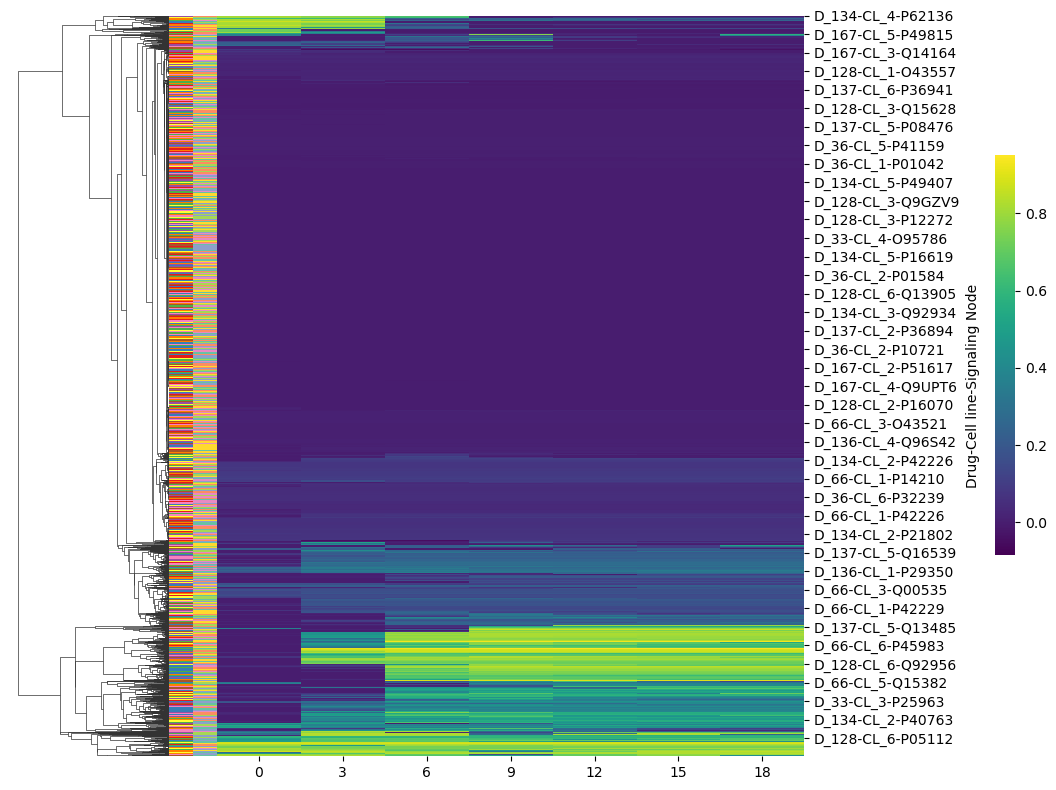

In [4]:
synthetic_data_plot = synthetic_data_filtered.copy()
annotations = synthetic_data_plot.index.to_frame(index=False)

drug_colors = sns.color_palette("Set1", len(annotations['Drug'].unique()))
cell_line_colors = sns.color_palette("Set2", len(annotations['Cell line'].unique()))

drug_lut = dict(zip(annotations['Drug'].unique(), drug_colors))
cell_line_lut = dict(zip(annotations['Cell line'].unique(), cell_line_colors))

row_colors = pandas.DataFrame({
    'Drug': annotations['Drug'].map(drug_lut),
    'Cell line': annotations['Cell line'].map(cell_line_lut)
})
drug_colors = row_colors['Drug']
cell_line_colors = row_colors['Cell line']

sns.clustermap(
    synthetic_data_plot, 
    cmap='viridis', 
    figsize=(10, 8), 
    col_cluster=False, 
    row_colors=[drug_colors, cell_line_colors], 
    cbar_pos=(1, 0.3, .02, .5),
    dendrogram_ratio=(.2, 0))
plt.show()

,Drug,Cell line,Signaling Node,Time,Value
0,D_167,CL_1,Q13233,0,-0.000481
1,D_167,CL_2,Q13233,0,-0.000599
2,D_167,CL_3,Q13233,0,-0.000512
3,D_167,CL_4,Q13233,0,-0.000495
4,D_167,CL_5,Q13233,0,-0.000572


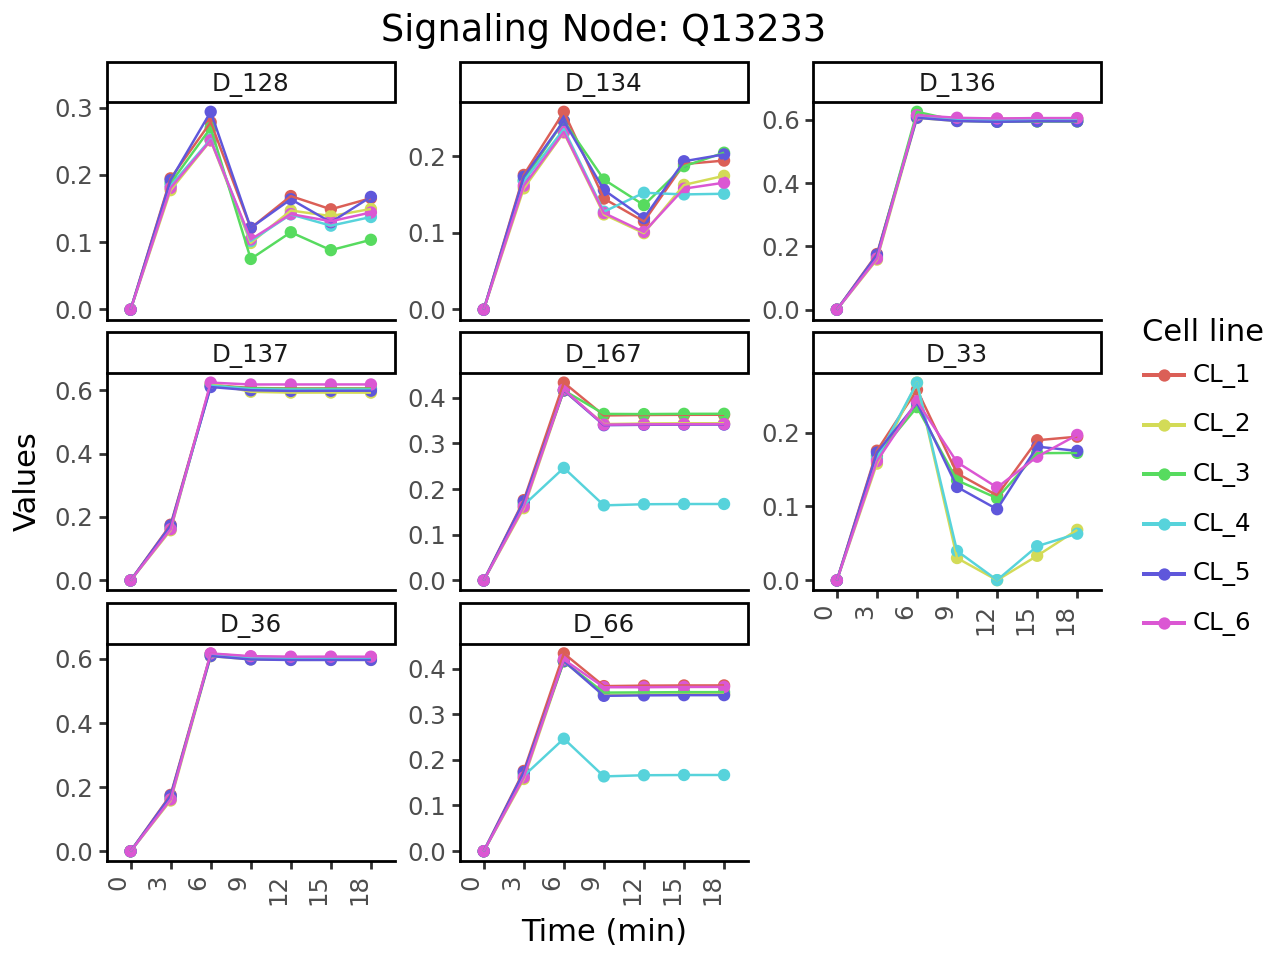

In [10]:
signaling_node = 'Q13233'

idx = pandas.IndexSlice
specific_rows = synthetic_data_filtered.loc[idx[:, :, signaling_node], :]
specific_rows = specific_rows.reset_index()
specific_rows = specific_rows.melt(id_vars=['Drug', 'Cell line', 'Signaling Node'], var_name='Time', value_name='Value')
display(specific_rows.head())

plot = (p9.ggplot(specific_rows, p9.aes(x='Time', y='Value', color='Cell line', group='Cell line'))
        + p9.geom_point()
        + p9.geom_line()
        + p9.facet_wrap('~Drug', scales='free_y')
        + p9.labs(title=f'Signaling Node: {signaling_node}', x='Time (min)', y='Values')
        + p9.theme_classic()
        + p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1)))

plot.show()

## Process Data to be Exported

Reformat `fullYFull` in order to have common Drug_CL_Time index and Genes as columns. Also, store mapping dataset (Drug_CL_Time -> Time point), so we can track which Drug_CL_Time maps to which Y time point when calculating the loss for the toy-model.

In [9]:
synthetic_data_melted = synthetic_data_filtered.reset_index().melt(id_vars=['Drug', 'Cell line', 'Signaling Node'], var_name='Time point', value_name='Value')
synthetic_data_melted['Drug_CL_Time'] = synthetic_data_melted['Drug'].astype(str) + '_' + synthetic_data_melted['Cell line'].astype(str) + '_' + synthetic_data_melted['Time point'].astype(str)
synthetic_data_pivoted = synthetic_data_melted.pivot(index='Drug_CL_Time', columns='Signaling Node', values='Value')
synthetic_data_final = synthetic_data_melted[['Drug_CL_Time', 'Time point']].drop_duplicates().set_index('Drug_CL_Time')
synthetic_data_final = synthetic_data_final.merge(synthetic_data_pivoted, left_index=True, right_index=True)

# Create a new mapping-dataset with Drug_CL_Time and Time point
condition_time_df = synthetic_data_final[['Time point']].reset_index()

synthetic_data_final.drop(columns=['Time point'], inplace=True)  # Delete Time point column from the synthetic dataset

display(condition_time_df.head())
display(synthetic_data_final)

,Drug_CL_Time,Time point
0,D_167_CL_1_0,0
1,D_167_CL_2_0,0
2,D_167_CL_3_0,0
3,D_167_CL_4_0,0
4,D_167_CL_5_0,0


,O00206,O14492,O14511,O14640,O14727,O14733,O14763,O14788,O14920,O14944,...,Q9UPT6,Q9UQC2,Q9Y243,Q9Y2X7,Q9Y4D1,Q9Y4H2,Q9Y4K3,Q9Y6K9,Q9Y6N7,Q9Y6Q6
Drug_CL_Time,,,,,,,,,,,,,,,,,,,,,
D_167_CL_1_0,-0.000144,0.016219,0.006156,-0.000369,0.001122,-0.002223,-0.000238,0.002359,-0.004913,0.008938,...,-0.002237,0.085965,-0.000518,0.185680,0.057001,-0.000417,0.027297,-0.001757,-0.000055,0.066225
D_167_CL_2_0,0.002766,0.013666,0.015646,-0.000297,0.008266,-0.002140,-0.000306,-0.000065,-0.004890,0.008250,...,-0.002251,0.071091,-0.000474,0.198054,0.050526,-0.000293,0.024632,-0.001816,-0.000245,0.054214
D_167_CL_3_0,-0.000149,0.017462,0.016929,-0.000370,0.005108,-0.002123,-0.000291,-0.000031,-0.004948,0.014576,...,-0.002333,0.074628,-0.000613,0.191912,0.060224,-0.000364,0.031500,-0.001667,-0.000049,0.058876
D_167_CL_4_0,-0.000060,0.026361,0.002622,-0.000216,0.008973,-0.002135,-0.000248,0.003383,-0.005007,0.008066,...,-0.002361,0.075843,-0.000538,0.199150,0.050690,-0.000352,0.017970,-0.001666,-0.000238,0.054548
D_167_CL_5_0,-0.000027,0.016923,0.008688,-0.000342,-0.000047,-0.002075,-0.000215,0.002593,-0.004859,0.008066,...,-0.002388,0.083714,-0.000436,0.184925,0.042342,-0.000402,0.027173,-0.001727,-0.000064,0.056379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_134_CL_2_18,0.561440,0.012796,0.015646,-0.000298,0.008266,-0.000086,-0.000297,-0.000065,-0.004680,0.008250,...,-0.000525,0.062515,0.230075,0.305952,0.050235,-0.002392,0.610484,-0.006858,-0.000249,0.054165
D_134_CL_3_18,0.549113,0.016561,0.016929,-0.000338,0.005107,-0.000344,-0.000293,-0.000031,-0.004785,0.014576,...,-0.000413,0.219862,0.291497,0.301602,0.059893,-0.002699,0.615503,-0.006751,-0.000052,0.058852
D_134_CL_4_18,0.560838,0.025478,0.002622,-0.000216,0.009061,0.322915,-0.000248,0.719914,-0.003800,0.008066,...,-0.000700,0.066951,0.275099,0.301193,0.050479,-0.002371,0.610762,-0.006709,-0.000241,0.581775


In [7]:
"""X['Condition'] = X.index
X_final = X.loc[X.index.repeat(dim3)].reset_index(drop=True)
X_final['Time point'] = numpy.tile(range(dim3), dim1)
X_final['Condition_Time'] = X_final['Condition'].astype(str) + '_' + X_final['Time point'].astype(str)
X_final.set_index('Condition_Time', inplace=True)
X_final.drop(columns=['Condition', 'Time point'], inplace=True)

X_final = X_final.loc[synthetic_data_final.index]"""
X_final = X_filtered.copy()
X_final['Drug_CL'] = X_final.index.get_level_values('Drug') + '_' + X_final.index.get_level_values('Cell line')
X_final.set_index('Drug_CL', inplace=True)
X_final.index.name = 'Drug_CL'
display(X_final.head())

,O14511,O14788,O14944,O43557,O75093,O75094,O75326,O94813,O96014,P00734,...,Q8NHW4,Q8WWG1,Q96A98,Q96B86,Q96S42,Q99075,Q9GZV9,Q9NPF7,Q9NSA1,Q9NT99
Drug_CL,,,,,,,,,,,,,,,,,,,,,
D_167_CL_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
D_167_CL_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.854832
D_167_CL_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
D_167_CL_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
D_167_CL_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


## Export Data

In [8]:
synthetic_data_final.to_csv('data/synthetic_data_y.csv', index=True)
X_final.to_csv('data/synthetic_data_x.csv', index=True)
condition_time_df.to_csv('data/synthetic_data_xtime.csv', index=True)